In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
#from sklearn_extra.cluster import KMedoids # pip install scikit-learn-extra

import matplotlib.pyplot as plt



In [56]:
data = pd.read_csv('ar41_for_ulb_cleaned.csv', delimiter=';')

## Scaling

In [57]:
# Select the relevant columns for clustering
features = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
            'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1',
            'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'temperature',
            'precipitation', 'windspeed_10m', 'sum_pollen']


# drop timestamp feature
#data = data.drop(columns=['timestamps_UTC'])

# Extract the selected features from the DataFrame
X = data[features]

# Standardize (robust) the data
Robustscaler = RobustScaler() # Test with robust scaler
X_Robustscaled = Robustscaler.fit_transform(X)

# Standardize (standard) the data
standardscaler = StandardScaler()
X_Standardscaled = standardscaler.fit_transform(X)



## K-means

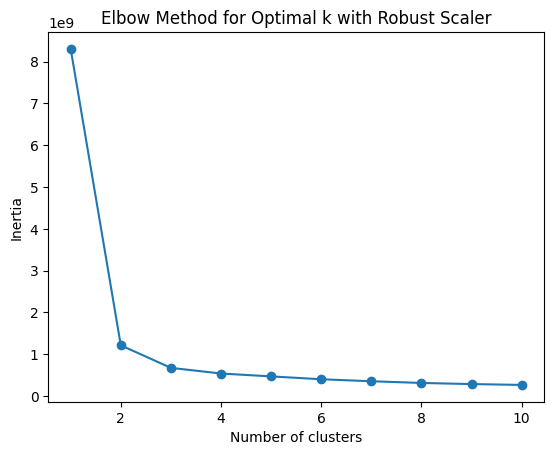

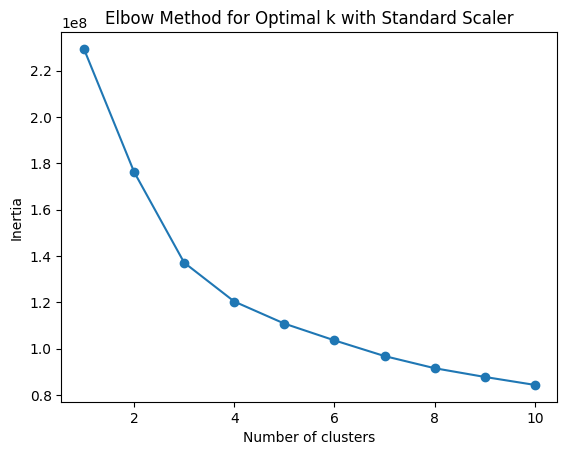

In [58]:
# Find the optimal number of clusters using the Elbow method


inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(X_Robustscaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k with Robust Scaler')
plt.show()

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(X_Standardscaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k with Standard Scaler')
plt.show()



In [59]:
# Choose an appropriate number of clusters (k) based on the Elbow curve
k = 2  # Adjust this value based on the Elbow curve

# Fit the K-means model
kmeansRobust = KMeans(n_clusters=k, random_state=0)
kmeansRobust.fit(X_Robustscaled)

k = 5  # Adjust this value based on the Elbow curve
kmeansStandard = KMeans(n_clusters=k, random_state=0)
kmeansStandard.fit(X_Standardscaled)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [63]:
# Add cluster labels to the original DataFrame
data['cluster_Robust'] = kmeansRobust.labels_

# Calculate the distance of each point to its assigned cluster center
data['distance_to_center_Robust'] = np.min(kmeansRobust.transform(X_Robustscaled), axis=1)

# Add cluster labels to the original DataFrame
data['cluster_Standard'] = kmeansStandard.labels_

# Calculate the distance of each point to its assigned cluster center
data['distance_to_center_Standard'] = np.min(kmeansStandard.transform(X_Standardscaled), axis=1)

In [ ]:
"""
max_temp_air = 65
max_temp_water = 100
max_temp_oil = 115

min_temp = 2

# Get cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame to hold the cluster centroids
cluster_centroids_df = pd.DataFrame(cluster_centers, columns=features)

# Define acceptable ranges for each feature
acceptable_ranges = {
    'RS_E_InAirTemp_PC1': (min_temp, max_temp_air),
    'RS_E_InAirTemp_PC2': (min_temp, max_temp_air),
    'RS_E_WatTemp_PC1': (min_temp, max_temp_water),
    'RS_E_WatTemp_PC2': (min_temp, max_temp_water),
    'RS_T_OilTemp_PC1': (min_temp, max_temp_oil),
    'RS_T_OilTemp_PC2': (min_temp, max_temp_oil),
}

# Check for clusters with centroids outside acceptable ranges
abnormal_clusters = []
for cluster_idx, centroid in enumerate(cluster_centers):
    is_abnormal = False
    for feature, (min_value, max_value) in acceptable_ranges.items():
        if centroid[features.index(feature)] < min_value or centroid[features.index(feature)] > max_value:
            is_abnormal = True
            break
    if is_abnormal:
        abnormal_clusters.append(cluster_idx)

abnormal_clusters
"""

In [ ]:
"""
feature1 = 'RS_E_InAirTemp_PC1'
feature2 = 'RS_E_InAirTemp_PC2'

plt.figure(figsize=(8, 6))
plt.scatter(data[feature1], data[feature2], c=data['cluster'], cmap='viridis')
plt.title('Clustering Results')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()
"""

Moyenne des clusters

In [64]:
means = data.groupby('cluster_Robust').mean()
means



/var/folders/fj/rsg75z_s7cq8mvy8kr0fb2ym0000gn/T/ipykernel_20022/938507153.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data.groupby('cluster_Robust').mean()


,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temperature,precipitation,windspeed_10m,sum_pollen,cluster_Standard,distance_to_center_Robust,distance_to_center_Standard
cluster_Robust,,,,,,,,,,,,,,,,,,,,
0,150.398202,50.856209,4.211245,28.600615,28.596803,253.541057,261.639193,810.089789,809.951414,77.364515,76.621501,76.074155,75.647129,12.374756,0.102640,13.295779,17.601001,0.826299,4.056623,2.301428
1,151.679374,50.934994,4.285085,36.729107,36.917638,372.128324,381.366095,1591.579291,1593.489794,83.662206,83.017941,85.016255,84.930425,13.021023,0.107279,13.507855,17.790671,2.931939,13.432959,2.566588


In [65]:
means = data.groupby('cluster_Standard').mean()
means

/var/folders/fj/rsg75z_s7cq8mvy8kr0fb2ym0000gn/T/ipykernel_20022/3950800550.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data.groupby('cluster_Standard').mean()


,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temperature,precipitation,windspeed_10m,sum_pollen,cluster_Robust,distance_to_center_Robust,distance_to_center_Standard
cluster_Standard,,,,,,,,,,,,,,,,,,,,
0,150.447340,50.869145,4.242003,20.790023,21.205788,251.589306,266.456867,812.218034,811.597760,76.304005,75.211751,74.585787,73.739776,7.663260,0.069189,13.495281,10.451355,0.013274,3.468617,2.355376
1,150.640398,50.866902,4.190679,36.523253,36.273264,219.908578,223.872102,814.031259,814.452891,82.736691,82.353345,83.009163,82.965675,16.173917,0.054458,13.110308,23.366611,0.004167,3.785608,2.012074
2,149.871767,50.798115,4.203929,15.872679,15.530323,398.331875,403.479235,807.452154,807.593839,54.693587,53.274431,47.470734,46.536988,9.351217,0.074519,13.183364,16.261377,0.013097,7.426625,3.169555
3,151.334283,50.918172,4.286080,37.142896,37.387994,380.019412,389.805999,1572.314179,1573.782343,83.902806,83.319688,85.182546,85.155300,13.162120,0.067414,13.528717,18.247202,0.953167,13.226024,2.590867
4,150.401642,50.870808,4.209227,33.331122,33.186991,263.732204,264.602649,944.714525,943.029031,81.106419,80.506704,81.179227,80.685402,15.724426,2.378025,14.665147,3.531994,0.176969,5.964751,3.557826


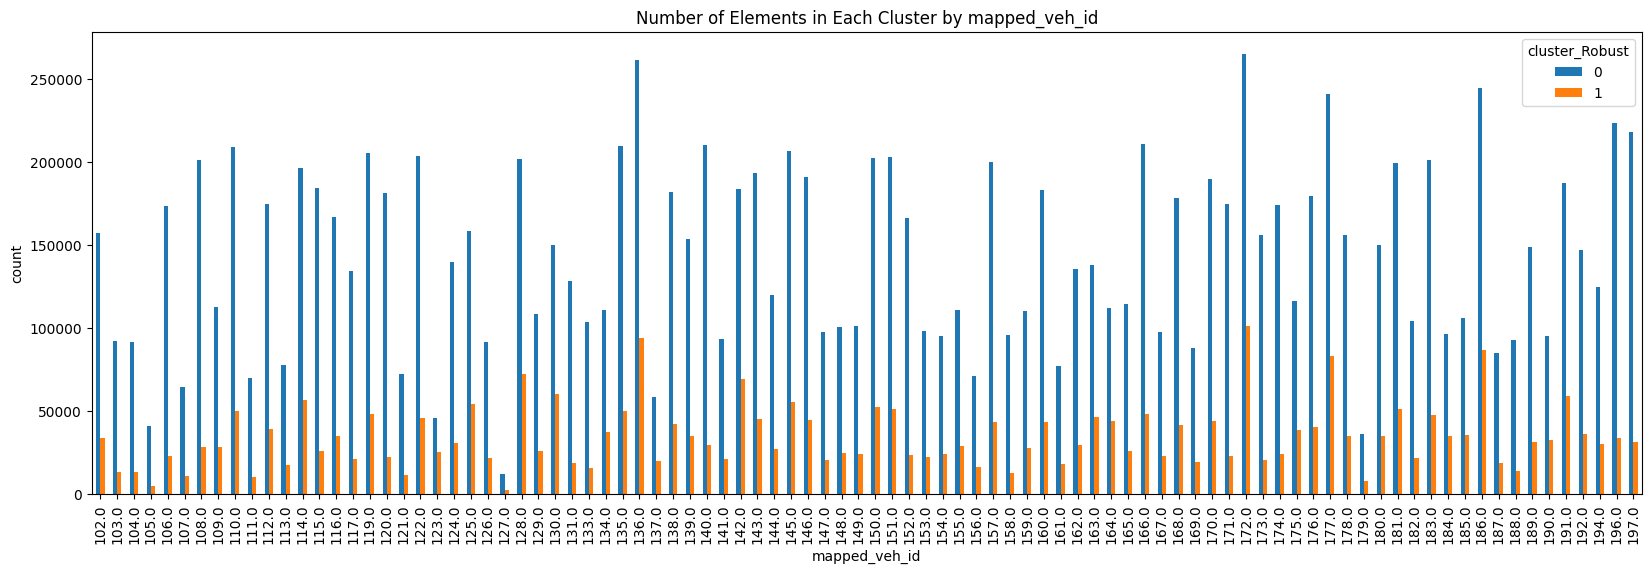

In [74]:
# Group the data by 'mapped_veh_id' and 'cluster_Robust' and calculate the count
cluster_elements = data.groupby(['mapped_veh_id', 'cluster_Robust']).size().reset_index(name='count')

# Pivot the data to have 'mapped_veh_id' as the index, 'cluster_Robust' as the columns, and 'count' as the values
pivot_data = cluster_elements.pivot(index='mapped_veh_id', columns='cluster_Robust', values='count')

# Plot the bar graph
pivot_data.plot(kind='bar', stacked=False, figsize=(20, 6))
plt.xlabel('mapped_veh_id')
plt.ylabel('count')
plt.title('Number of Elements in Each Cluster by mapped_veh_id')
plt.show()


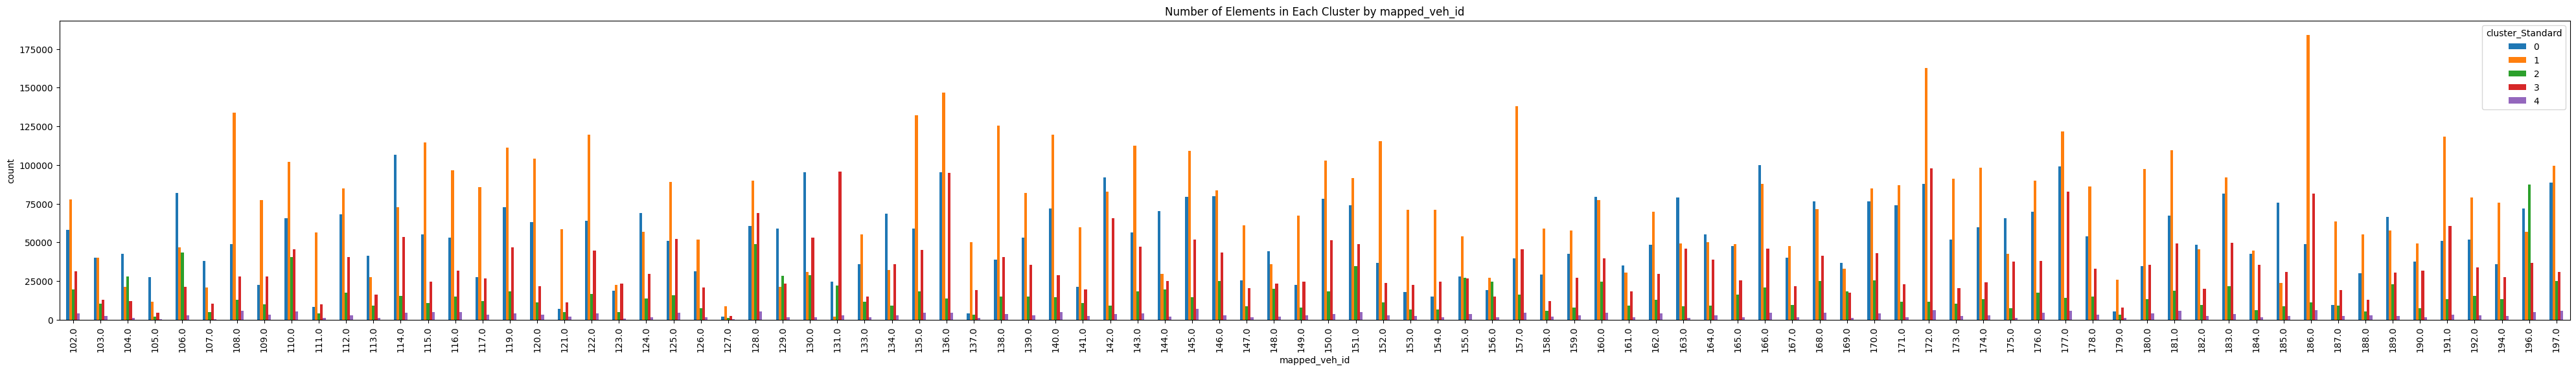

In [73]:
# Group the data by 'mapped_veh_id' and 'cluster_Standard' and calculate the count
cluster_elements = data.groupby(['mapped_veh_id', 'cluster_Standard']).size().reset_index(name='count')

# Pivot the data to have 'mapped_veh_id' as the index, 'cluster_Standard' as the columns, and 'count' as the values
pivot_data = cluster_elements.pivot(index='mapped_veh_id', columns='cluster_Standard', values='count')

# Plot the bar graph
pivot_data.plot(kind='bar', stacked=False, figsize=(50, 6))
plt.xlabel('mapped_veh_id')
plt.ylabel('count')
plt.title('Number of Elements in Each Cluster by mapped_veh_id')
plt.show()

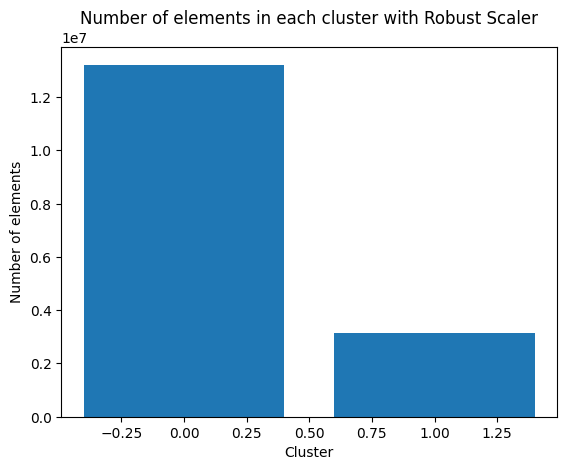

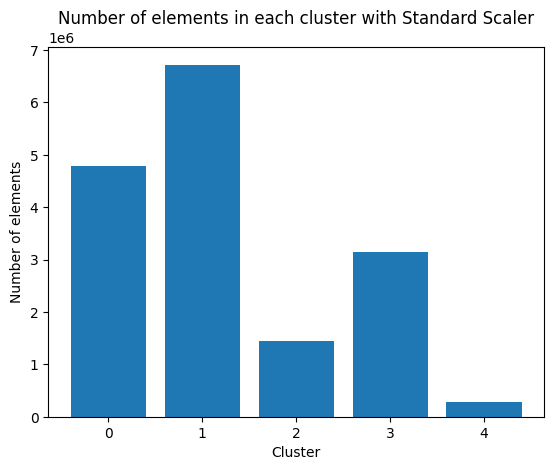

In [67]:
# count the number of elements in each cluster
cluster_elements = data.groupby(['cluster_Robust']).size().reset_index(name='count')
# plot the results
plt.bar(cluster_elements['cluster_Robust'], cluster_elements['count'])
plt.xlabel('Cluster')
plt.ylabel('Number of elements')
plt.title('Number of elements in each cluster with Robust Scaler')
plt.show()

# count the number of elements in each cluster
cluster_elements = data.groupby(['cluster_Standard']).size().reset_index(name='count')
# plot the results
plt.bar(cluster_elements['cluster_Standard'], cluster_elements['count'])
plt.xlabel('Cluster')
plt.ylabel('Number of elements')
plt.title('Number of elements in each cluster with Standard Scaler')
plt.show()
